In [ ]:
print("hello")

In [1]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

url = "http://farm4.staticflickr.com/3300/3416216247_f9c6dfc939_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", low_cpu_mem_usage=True)
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device, low_cpu_mem_usage=True)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("yonigozlan/synthpose-vitpose-huge-hf")
model = VitPoseForPoseEstimation.from_pretrained("yonigozlan/synthpose-vitpose-huge-hf", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image


c:\Users\My PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
image_pose_result

[{'keypoints': tensor([[115.6148, 176.0780],
          [113.6294, 170.3812],
          [114.2325, 175.3082],
          [113.8949, 157.8701],
          [117.5240, 169.3940],
          [129.8349, 144.3687],
          [154.5537, 162.2428],
          [ 88.1156, 150.1119],
          [177.5821, 185.8109],
          [ 50.2765, 159.1557],
          [161.5992, 209.4293],
          [205.3853, 179.8414],
          [228.7198, 170.7070],
          [225.2470, 253.5599],
          [265.8868, 230.0539],
          [272.5794, 306.7758],
          [329.9837, 259.7065],
          [141.9300, 165.6186],
          [147.8249, 164.2754],
          [126.9728, 145.2506],
          [173.8137, 182.7282],
          [ 88.1344, 146.2639],
          [183.0160, 186.1802],
          [ 90.6082, 151.5826],
          [158.8177, 207.3312],
          [ 50.6266, 157.7399],
          [162.7002, 209.6620],
          [ 49.6100, 156.2879],
          [215.4672, 177.0105],
          [191.8852, 186.9354],
          [216.1628, 157.65

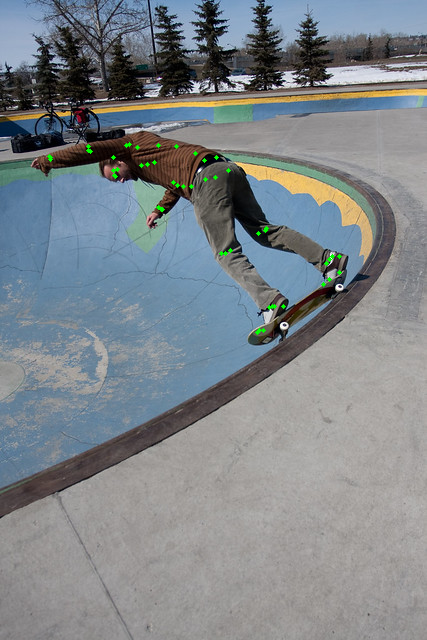

In [5]:
import supervision as sv

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.GREEN,
    radius=2
)

annotated_frame = vertex_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame


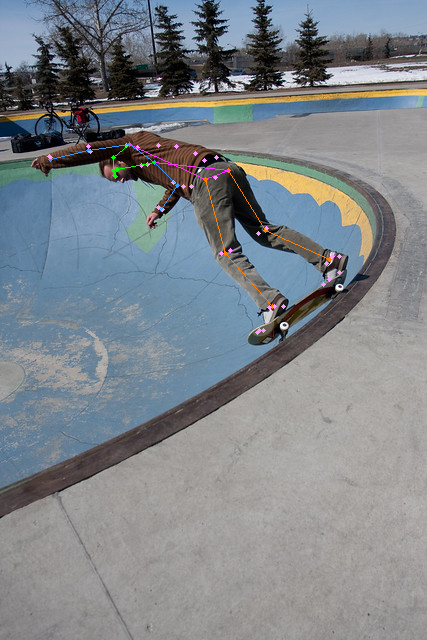

In [9]:
import math
import cv2

def draw_points(image, keypoints, scores, pose_keypoint_color, keypoint_score_threshold, radius, show_keypoint_weight):
    if pose_keypoint_color is not None:
        assert len(pose_keypoint_color) == len(keypoints)
    for kid, (kpt, kpt_score) in enumerate(zip(keypoints, scores)):
        x_coord, y_coord = int(kpt[0]), int(kpt[1])
        if kpt_score > keypoint_score_threshold:
            color = tuple(int(c) for c in pose_keypoint_color[kid])
            if show_keypoint_weight:
                cv2.circle(image, (int(x_coord), int(y_coord)), radius, color, -1)
                transparency = max(0, min(1, kpt_score))
                cv2.addWeighted(image, transparency, image, 1 - transparency, 0, dst=image)
            else:
                cv2.circle(image, (int(x_coord), int(y_coord)), radius, color, -1)

def draw_links(image, keypoints, scores, keypoint_edges, link_colors, keypoint_score_threshold, thickness, show_keypoint_weight, stick_width = 2):
    height, width, _ = image.shape
    if keypoint_edges is not None and link_colors is not None:
        assert len(link_colors) == len(keypoint_edges)
        for sk_id, sk in enumerate(keypoint_edges):
            x1, y1, score1 = (int(keypoints[sk[0], 0]), int(keypoints[sk[0], 1]), scores[sk[0]])
            x2, y2, score2 = (int(keypoints[sk[1], 0]), int(keypoints[sk[1], 1]), scores[sk[1]])
            if (
                x1 > 0
                and x1 < width
                and y1 > 0
                and y1 < height
                and x2 > 0
                and x2 < width
                and y2 > 0
                and y2 < height
                and score1 > keypoint_score_threshold
                and score2 > keypoint_score_threshold
            ):
                color = tuple(int(c) for c in link_colors[sk_id])
                if show_keypoint_weight:
                    X = (x1, x2)
                    Y = (y1, y2)
                    mean_x = np.mean(X)
                    mean_y = np.mean(Y)
                    length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
                    angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
                    polygon = cv2.ellipse2Poly(
                        (int(mean_x), int(mean_y)), (int(length / 2), int(stick_width)), int(angle), 0, 360, 1
                    )
                    cv2.fillConvexPoly(image, polygon, color)
                    transparency = max(0, min(1, 0.5 * (keypoints[sk[0], 2] + keypoints[sk[1], 2])))
                    cv2.addWeighted(image, transparency, image, 1 - transparency, 0, dst=image)
                else:
                    cv2.line(image, (x1, y1), (x2, y2), color, thickness=thickness)


# Note: keypoint_edges and color palette are dataset-specific
keypoint_edges = model.config.edges

palette = np.array(
    [
        [255, 128, 0],
        [255, 153, 51],
        [255, 178, 102],
        [230, 230, 0],
        [255, 153, 255],
        [153, 204, 255],
        [255, 102, 255],
        [255, 51, 255],
        [102, 178, 255],
        [51, 153, 255],
        [255, 153, 153],
        [255, 102, 102],
        [255, 51, 51],
        [153, 255, 153],
        [102, 255, 102],
        [51, 255, 51],
        [0, 255, 0],
        [0, 0, 255],
        [255, 0, 0],
        [255, 255, 255],
    ]
)

link_colors = palette[[0, 0, 0, 0, 7, 7, 7, 9, 9, 9, 9, 9, 16, 16, 16, 16, 16, 16, 16]]
keypoint_colors = palette[[16, 16, 16, 16, 16, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0]+[4]*(52-17)]

numpy_image = np.array(image)

for pose_result in image_pose_result:
    scores = np.array(pose_result["scores"])
    keypoints = np.array(pose_result["keypoints"])

    # draw each point on image
    draw_points(numpy_image, keypoints, scores, keypoint_colors, keypoint_score_threshold=0.3, radius=2, show_keypoint_weight=False)

    # draw links
    draw_links(numpy_image, keypoints, scores, keypoint_edges, link_colors, keypoint_score_threshold=0.3, thickness=1, show_keypoint_weight=False)

pose_image = Image.fromarray(numpy_image)
pose_image


In [11]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-small")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-small", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs, dataset_index=torch.tensor([0], device=device))

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
image_pose_result = pose_results[0]  # results for first image

for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")


Person #0
 - Nose: x=429.30, y=171.11, score=0.91
 - L_Eye: x=429.67, y=168.14, score=0.93
 - R_Eye: x=429.03, y=168.32, score=0.82
 - L_Ear: x=434.87, y=166.54, score=0.88
 - R_Ear: x=441.23, y=165.41, score=0.88
 - L_Shoulder: x=440.11, y=177.35, score=0.93
 - R_Shoulder: x=446.30, y=178.77, score=0.71
 - L_Elbow: x=436.34, y=197.83, score=0.87
 - R_Elbow: x=433.29, y=201.44, score=0.67
 - L_Wrist: x=429.38, y=216.47, score=0.83
 - R_Wrist: x=421.43, y=213.12, score=0.80
 - L_Hip: x=445.63, y=223.74, score=0.80
 - R_Hip: x=451.69, y=223.39, score=0.68
 - L_Knee: x=444.08, y=255.79, score=0.73
 - R_Knee: x=451.35, y=254.63, score=0.75
 - L_Ankle: x=453.37, y=287.65, score=0.69
 - R_Ankle: x=456.82, y=286.15, score=0.76
Person #1
 - Nose: x=398.27, y=181.60, score=0.87
 - L_Eye: x=398.54, y=179.82, score=0.83
 - R_Eye: x=396.05, y=179.42, score=0.90
 - R_Ear: x=389.23, y=180.09, score=0.85
 - L_Shoulder: x=396.92, y=194.29, score=0.69
 - R_Shoulder: x=384.28, y=190.44, score=0.53


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from urllib.parse import urlparse
import random

# 1. Simulate Synthetic Clickstream Data
def generate_clickstream_data(num_rows=1000):
    activities = ['gaming', 'shopping', 'coding', 'work']
    domains = {
        'gaming': ['steam.com', 'twitch.tv', 'roblox.com'],
        'shopping': ['amazon.com', 'ebay.com', 'shopee.vn'],
        'coding': ['github.com', 'stackoverflow.com', 'replit.com'],
        'work': ['notion.so', 'slack.com', 'zoom.us']
    }

    data = []
    for _ in range(num_rows):
        activity = random.choice(activities)
        domain = random.choice(domains[activity])
        duration = np.random.randint(10, 600)  # seconds
        data.append({
            'url': f'https://{domain}/some/page',
            'duration': duration,
            'device': random.choice(['desktop', 'mobile']),
            'activity': activity
        })
    return pd.DataFrame(data)

df = generate_clickstream_data()

# 2. Feature Engineering
def extract_domain(url):
    return urlparse(url).netloc

df['domain'] = df['url'].apply(extract_domain)
df = pd.get_dummies(df, columns=['device', 'domain'])

# 3. Prepare Data for Modeling
X = df.drop(columns=['url', 'activity'])
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      coding       1.00      1.00      1.00        55
      gaming       1.00      1.00      1.00        48
    shopping       1.00      1.00      1.00        41
        work       1.00      1.00      1.00        56

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



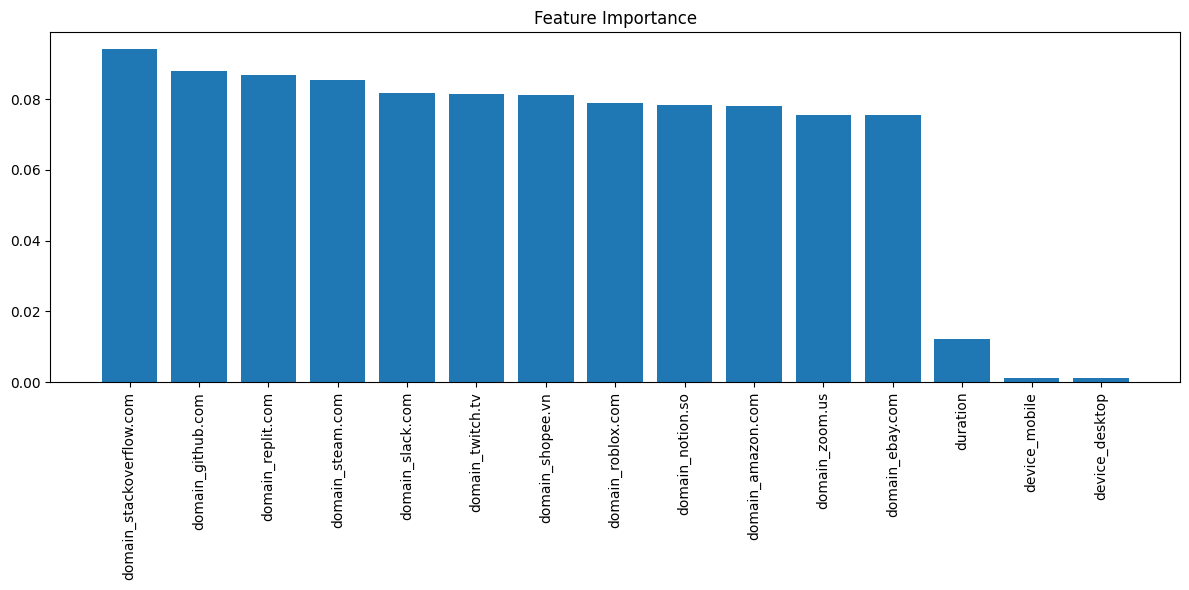

In [14]:
import matplotlib.pyplot as plt

# Get feature importances from RandomForest
importances = model.feature_importances_
feature_names = X.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [15]:
def simulate_sessions(num_sessions=300):
    activities = ['gaming', 'shopping', 'coding', 'work']
    domains = {
        'gaming': ['steam.com', 'twitch.tv', 'roblox.com'],
        'shopping': ['amazon.com', 'ebay.com', 'shopee.vn'],
        'coding': ['github.com', 'stackoverflow.com', 'replit.com'],
        'work': ['notion.so', 'slack.com', 'zoom.us']
    }

    data = []
    for session_id in range(num_sessions):
        activity = random.choice(activities)
        for _ in range(np.random.randint(3, 10)):  # simulate clicks
            domain = random.choice(domains[activity])
            data.append({
                'session_id': session_id,
                'url': f'https://{domain}/some/page',
                'duration': np.random.randint(10, 300),
                'device': random.choice(['desktop', 'mobile']),
                'activity': activity
            })
    return pd.DataFrame(data)

df = simulate_sessions()

# Extract domain
df['domain'] = df['url'].apply(extract_domain)

# Aggregate per session
agg_df = df.groupby('session_id').agg({
    'duration': 'sum',
    'device': lambda x: x.mode()[0],
    'activity': 'first',  # All clicks in a session are from same activity
    'domain': lambda x: ','.join(x)
}).reset_index()

# One-hot encode domains
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=lambda x: x.split(','))  # split by comma
X_domains = cv.fit_transform(agg_df['domain']).toarray()
domain_df = pd.DataFrame(X_domains, columns=cv.get_feature_names_out())

# Merge features
agg_df = pd.concat([agg_df.drop(columns=['domain']), domain_df], axis=1)
agg_df = pd.get_dummies(agg_df, columns=['device'])

# Model input
X = agg_df.drop(columns=['session_id', 'activity'])
y = agg_df['activity']


In [1]:
import argparse
import time
import os
from os.path import exists

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceEnum_ELBO, TraceTMC_ELBO, config_enumerate
from pyro.optim import ClippedAdam

import pdb


class Emitter(nn.Module):
    """
    Parameterizes the Categorical observation likelihood `p(x_t | z_t)`
    """
    def __init__(self, input_dim, z_dim, emission_dim, use_feature_mask_emitter, min_x_scale):
        super().__init__()
        
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, z_t, mini_batch_feature_mask_t=None):

        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        ps = self.softmax(self.lin_hidden_to_input(h2))

        return ps




class Emitter_time(nn.Module):
    """
    Parameterizes the gaussian emission probability of time `p(t_t | z_t)`
    """
    def __init__(self, z_dim, emission_dim, min_x_scale):
        super().__init__()

        self.min_x_scale = min_x_scale
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_gate_hidden_to_t = nn.Linear(emission_dim, 1)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_proposed_mean_hidden_to_t = nn.Linear(emission_dim, 1)
        self.lin_sig = nn.Linear(1, 1)
        self.lin_z_to_loc = nn.Linear(z_dim, 1)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        #self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        #self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t):
        """
        Given the latent `z_t` corresponding to the time step t
        we return the mean and scale vectors that parameterize the 
        gaussian distribution `p(t_t | z_t)`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t))
        gate = torch.sigmoid(self.lin_gate_hidden_to_t(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t))
        proposed_mean = self.lin_proposed_mean_hidden_to_t(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        scale = scale.add(self.min_x_scale)
        return loc, scale


class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    """

    def __init__(self, z_dim, static_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.concat_dim = z_dim + static_dim
        self.lin_gate_z_to_hidden = nn.Linear(self.concat_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(self.concat_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, mini_batch_static):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        concat = torch.cat((z_t_1, mini_batch_static),dim=1)
        _gate = self.relu(self.lin_gate_z_to_hidden(concat))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(concat))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, s, x_{t:T}, t_{t:T})`
    """

    def __init__(self, z_dim, static_dim, rnn_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.concat_dim = z_dim + static_dim
        self.lin_z_to_hidden = nn.Linear(self.concat_dim , rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(2*rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(2*rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, mini_batch_static, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        concat = torch.cat((z_t_1, mini_batch_static),dim=1)
        projected_concat = self.lin_z_to_hidden(concat)
        #h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(concat)) + h_rnn)
        h_combined = torch.cat((projected_concat, h_rnn),dim=1)

        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale

def transform_diff_t(diff_t):
    #Convert seconds to minutes, then take the log
    diff_t = diff_t/60 + 1
    diff_t = diff_t.log()
    return diff_t

class Predicter_Attention(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(y | z_T)`
    """
    def __init__(self, z_dim, att_dim, MLP_dims, time2vec_out=8, batch_first=True, use_cuda=True):
        super(Predicter_Attention, self).__init__() 
        self.z_dim = z_dim
        self.att_dim = att_dim
        self.MLP_dims = MLP_dims

        #Context vector is a parameter to measure the relevance of provided vector for y prediction
        bound = 1/np.sqrt(att_dim)
        self.context_vec = nn.Parameter(torch.zeros(att_dim, 1).uniform_(-bound, bound))
        #In attention framework, z_t's will be projected first
        self.projection_layer = nn.Linear(z_dim, att_dim)
        #There will be an activation function after projection
        self.tanh = nn.Tanh()
        #We use Beta Parameter to control sharpness/smoothness of Softmax function
        #self.Beta = torch.Tensor([0.1]).cuda()
        self.logBeta = torch.nn.Parameter(torch.Tensor([0]))
        #self.Beta = nn.Parameter(torch.ones(1))


        #We accepts MLP_dims as strings i.e. "48-24-12-..."
        #If MLP_dims is "-", it implies that there will be no middle layer
        if MLP_dims == "-":
            middle_layers = []
        else:
            middle_layers = MLP_dims.split("-")
        all_MLP_dimensions = [z_dim]
        for i in middle_layers:
            all_MLP_dimensions.append(int(i))
        #Last dim will be 1 for binary classification
        all_MLP_dimensions.append(1)
        self.lin_layers_nn = nn.ModuleList()
        for i in range(len(all_MLP_dimensions)-1):
            self.lin_layers_nn.append(nn.Linear(all_MLP_dimensions[i], all_MLP_dimensions[i+1]))

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, cum_t, mini_batch_mask):
        cum_t = cum_t.squeeze(-1)
        diff_t = cum_t.max(dim=1, keepdim=True)[0] - cum_t #shape of (N,T)
        #Transform diff_t -> Convert to minute then take log
        transformed_diff_t = transform_diff_t(diff_t)

        #Note: z here has the shape of (N,T,z_dim)
        z_2d = z.reshape(-1, z.shape[2]) #shape of (N*T, z_dim)
        z_projected = self.tanh(self.projection_layer(z_2d)) #Now z_projected has the shape (N*T, att_dim)

        #Calculate weights (alpha) of z_projected
        #Below line is used originally (1)
        alpha = torch.mm(z_projected, self.context_vec) / np.sqrt(self.att_dim) #shape of alpha = (N*T,1)

        alpha = alpha.reshape(z.shape[0], z.shape[1]) #shape of alpha = (N,T)
        alpha = alpha - self.logBeta.exp() * transformed_diff_t
        alpha = alpha.masked_fill(mini_batch_mask == 0, -1e9)
        alpha = torch.softmax(alpha, dim=-1) #shape of alpha = (N,T)

        
        alpha = alpha.unsqueeze(-1).expand((alpha.shape + (z.shape[2],))) #shape of alpha = (N,T, z_dim)

        #Multiply z and alpha elementwise
        new_z = z * alpha #shape of new_z = (N,T, z_dim)
        #new_z = z_projected.reshape(z.shape[0], z.shape[1],-1) * alpha
        new_z = new_z.sum(axis=1) #shape of new_z = (N, z_dim)



        input_MLP = new_z
        for i in range(len(self.lin_layers_nn)-1):
            input_MLP = self.relu(self.lin_layers_nn[i](input_MLP))

        prob_out = self.sigmoid(self.lin_layers_nn[-1](input_MLP))
        return prob_out.flatten()

# this function takes a torch mini-batch and reverses each sequence
# (w.r.t. the temporal axis, i.e. axis=1).
def reverse_sequences(mini_batch, seq_lengths):
    reversed_mini_batch = torch.zeros_like(mini_batch)
    for b in range(mini_batch.size(0)):
        T = seq_lengths[b]
        time_slice = torch.arange(T - 1, -1, -1, device=mini_batch.device)
        reversed_sequence = torch.index_select(mini_batch[b, :, :], 0, time_slice)
        reversed_mini_batch[b, 0:T, :] = reversed_sequence
    return reversed_mini_batch

def get_mini_batch_mask(mini_batch, seq_lengths):
    mask = torch.zeros(mini_batch.shape[0:2])
    for b in range(mini_batch.shape[0]):
        mask[b, 0:seq_lengths[b]] = torch.ones(seq_lengths[b])
    return mask

def batchify(sequences, seq_lengths, sequences_feature_mask, static, y_sequence, y_mask_sequence, deltatime, cumtime, max_len=720, batch_size=128, use_feature_mask=True, cuda=True):

    keep_index = np.where(np.logical_and(seq_lengths <= max_len, seq_lengths > 0))[0]

    static = static[keep_index]
    sequences = sequences[keep_index]
    seq_lengths = seq_lengths[keep_index]
    deltatime = deltatime[keep_index]
    cumtime = cumtime[keep_index]
    if sequences_feature_mask is not None:
        sequences_feature_mask = sequences_feature_mask[keep_index]
    if y_sequence is not None:
        y_sequence = y_sequence[keep_index]
    if y_mask_sequence is not None:
        y_mask_sequence = y_mask_sequence[keep_index]


    N_data = len(seq_lengths)
    N_mini_batches = int(N_data / batch_size +
                            int(N_data % batch_size > 0))

    shuffled_indices = np.arange(N_data)

    batches = []

    for which_mini_batch in range(N_mini_batches):
        mini_batch_start = (which_mini_batch * batch_size)
        mini_batch_end = np.min([(which_mini_batch + 1) * batch_size, N_data])
        mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]
        
        batches.append(get_mini_batch(mini_batch_indices, sequences, seq_lengths, sequences_feature_mask, static, y_sequence, y_mask_sequence, deltatime, cumtime, keep_index, use_feature_mask=use_feature_mask, cuda=cuda))

    return batches

def get_mini_batch(mini_batch_indices, sequences, seq_lengths, sequences_feature_mask=None, static=None, y_sequence=None, y_mask_sequence=None, deltatime=None, cumtime=None, indices_dataset=None, use_feature_mask=False, cuda=False):
    # get the sequence lengths of the mini-batch
    #sorted_seq_lengths and sorted_mini_batch_indices
    seq_lengths = seq_lengths[mini_batch_indices]
    seq_lengths = torch.from_numpy(seq_lengths).type('torch.LongTensor')

    # sort the sequence lengths
    _, sorted_seq_length_indices = torch.sort(seq_lengths)
    sorted_seq_length_indices = sorted_seq_length_indices.flip(0)
    sorted_seq_lengths = seq_lengths[sorted_seq_length_indices]
    sorted_mini_batch_indices = mini_batch_indices[sorted_seq_length_indices.numpy()]

    # compute the length of the longest sequence in the mini-batch
    T_max = torch.max(seq_lengths)
    # this is the sorted mini-batch
    mini_batch = list(map(lambda x: torch.from_numpy(x[:T_max,:]).type('torch.DoubleTensor') , sequences[sorted_mini_batch_indices]))
    mini_batch = pad_sequence(mini_batch, batch_first=True).type('torch.DoubleTensor')
    #This is the sorted mini_batch_static
    mini_batch_static = static[sorted_mini_batch_indices]
    mini_batch_static = torch.from_numpy(mini_batch_static).type('torch.DoubleTensor')
    #this is the sorted deltatime
    mini_batch_deltatime = list(map(lambda x: torch.from_numpy(x[:T_max]).type('torch.DoubleTensor') , deltatime[sorted_mini_batch_indices]))
    mini_batch_deltatime = pad_sequence(mini_batch_deltatime, batch_first=True).type('torch.DoubleTensor')
    mini_batch_deltatime = mini_batch_deltatime.reshape(mini_batch_deltatime.shape + (1,)) #the final shape is N*T*1 

    #We need one shift to left for rnn input at guide. When there is no-shift, combiner and rnn gets the same time-step (previous one) for the current latent variable.
    #By shifting left, rnn gets the future delta_time instead. After shift, right side is padded by 0.
    mini_batch_deltatime_rnn = torch.nn.functional.pad(mini_batch_deltatime, (0,0,0,1), "constant", 0)[:,1:,:]
    #Why (0,0,0,1)? -> Because no padding for last dimension, and we pad the right a 2nd to last dimension. 

    #this is the sorted cumtime
    mini_batch_cumtime = list(map(lambda x: torch.from_numpy(x[:T_max]).type('torch.DoubleTensor') , cumtime[sorted_mini_batch_indices]))
    mini_batch_cumtime = pad_sequence(mini_batch_cumtime, batch_first=True).type('torch.DoubleTensor')
    mini_batch_cumtime = mini_batch_cumtime.reshape(mini_batch_cumtime.shape + (1,)) #the final shape is N*T*1 

    # get mask for mini-batch
    mini_batch_mask = get_mini_batch_mask(mini_batch, sorted_seq_lengths)
    #get the y values (mortality labels) of mini-batch
    if y_sequence is None:
        y_mini_batch = None
    else:
        y_mini_batch = y_sequence[sorted_mini_batch_indices]
        y_mini_batch = torch.from_numpy(y_mini_batch).type('torch.DoubleTensor')

    #get y mask values (for semi-supervised learning)
    if y_mask_sequence is None:
        y_mask_mini_batch = None
    else:
        y_mask_mini_batch = y_mask_sequence[sorted_mini_batch_indices]
        y_mask_mini_batch = torch.from_numpy(y_mask_mini_batch).type('torch.DoubleTensor')


    #Below line was just for convenience
    mini_batch_feature_mask = None
    #mini_batch_reversed_with_mask = reverse_sequences(torch.cat((mini_batch, mini_batch_deltatime),dim=-1), sorted_seq_lengths)
    mini_batch_reversed_with_mask = reverse_sequences(torch.cat((mini_batch, mini_batch_deltatime_rnn),dim=-1), sorted_seq_lengths)

    # cuda() here because need to cuda() before packing
    if cuda:
        mini_batch = mini_batch.cuda()
        mini_batch_static = mini_batch_static.cuda()
        mini_batch_mask = mini_batch_mask.cuda()
        mini_batch_deltatime = mini_batch_deltatime.cuda()
        mini_batch_cumtime = mini_batch_cumtime.cuda()
        if y_mini_batch is not None:
            y_mini_batch = y_mini_batch.cuda()
        if y_mask_mini_batch is not None:
            y_mask_mini_batch = y_mask_mini_batch.cuda()
        mini_batch_reversed_with_mask = mini_batch_reversed_with_mask.cuda()
        if mini_batch_feature_mask is not None:
            mini_batch_feature_mask = mini_batch_feature_mask.cuda()
        
    # do sequence packing
    mini_batch_reversed_with_mask = nn.utils.rnn.pack_padded_sequence(mini_batch_reversed_with_mask,
                                                            sorted_seq_lengths,
                                                            batch_first=True)

    return mini_batch_static, mini_batch, mini_batch_reversed_with_mask, mini_batch_mask, sorted_seq_lengths, mini_batch_feature_mask, y_mini_batch, y_mask_mini_batch, mini_batch_deltatime, mini_batch_cumtime, indices_dataset[sorted_mini_batch_indices]



def pad_and_reverse(rnn_output, seq_lengths):
    rnn_output, _ = nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)
    reversed_output = reverse_sequences(rnn_output, seq_lengths)
    return reversed_output

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.amp import GradScaler, autocast

# Load dữ liệu người dùng
df = pd.read_csv("user_logs.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)

# Chia session theo thời gian giữa các hành vi không vượt quá 60 giây
sessions = []
labels = []
current_session = []
current_label = None
last_time = None

for _, row in df.iterrows():
    time = row['timestamp']
    action = f"{row['description']}|{row['event_type']}"

    if last_time is None or (time - last_time).total_seconds() <= 60:
        current_session.append(action)
    else:
        if current_session:
            sessions.append(current_session)
            labels.append(current_label if current_label else "other")
        current_session = [action]
    current_label = row['type'] if pd.notna(row['type']) else current_label
    last_time = time

if current_session:
    sessions.append(current_session)
    labels.append(current_label if current_label else "other")

# Mã hóa token và nhãn
token2idx = {}
idx = 1
encoded_sessions = []
for session in sessions:
    encoded = []
    for token in session:
        if token not in token2idx:
            token2idx[token] = idx
            idx += 1
        encoded.append(token2idx[token])
    encoded_sessions.append(encoded)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
vocab_size = len(token2idx) + 1
num_classes = len(label_encoder.classes_)

# Dataset & DataLoader
class SessionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = pad_sequence(sequences, batch_first=True)
    return padded_seqs, torch.tensor(labels), lengths
print(f"Tổng số session: {len(encoded_sessions)}")
if len(encoded_sessions) < 2:
    print("Too few sessions to split. Training on all.")
    X_train, y_train = encoded_sessions, encoded_labels
    X_val, y_val = encoded_sessions, encoded_labels
else:
    X_train, X_val, y_train, y_val = train_test_split(encoded_sessions, encoded_labels, test_size=0.2, random_state=42)

# Tách tập train/val
train_loader = DataLoader(SessionDataset(X_train, y_train), batch_size=4, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(SessionDataset(X_val, y_val), batch_size=4, shuffle=False, collate_fn=collate_fn, drop_last=True)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.ft = nn.Flatten()
        self.lora = nn.PReLU()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
            nn.Flatten(),
            nn.ReLU(inplace=True),
            nn.Dropout1d(dropout),
            nn.Softplus(hidden_dim),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (hn, _) = self.lstm(packed)
        out = self.bn(hn[-1])
        out = self.ft(out)
        out = self.lora(out)
        out = self.fc(out)
        return out
# Huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
embed_dims = [64, 128]
hidden_dims = [64, 128]
dropouts = [0.3, 0.7]
learning_rates = [0.001, 0.0005]

best_val_loss = float('inf')
best_params = {}

for embed_dim in embed_dims:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            for lr in learning_rates:
                print(f"Training with embed_dim={embed_dim}, hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}")
                
                model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes, dropout).to(device)
                class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
                class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                scaler = GradScaler(device=device)
                
                # Training Loop
                for epoch in range(50):
                    model.train()
                    total_loss = 0
                    for X_batch, y_batch, lengths in train_loader:
                        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)

                        optimizer.zero_grad()
                        with autocast(device_type='cuda'):
                            outputs = model(X_batch, lengths)
                            loss = criterion(outputs, y_batch)

                        scaler.scale(loss).backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()
                        total_loss += loss.item()
                    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

                    # Validation Phase
                    model.eval()
                    val_loss = 0
                    with torch.no_grad():
                        for X_batch, y_batch, lengths in val_loader:
                            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
                            outputs = model(X_batch, lengths)
                            loss = criterion(outputs, y_batch)
                            val_loss += loss.item()

                    print(f"Validation Loss after Epoch {epoch+1}: {val_loss:.4f}")
                    patience = 5
                    early_stop_counter = 0
                    best_epoch_val_loss = float('inf')
                    # Monitor for best validation loss
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = {
                            'embed_dim': embed_dim,
                            'hidden_dim': hidden_dim,
                            'dropout': dropout,
                            'lr': lr
                        }
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print("Early stopping triggered.")
                        break
                        
                print(f"Best validation loss: {best_val_loss:.4f} with params: {best_params}")


model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch, lengths in val_loader:
        X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
        output = model(X_batch, lengths)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y_batch.cpu().tolist())

report = classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(label_encoder.classes_))),
    target_names=label_encoder.classes_,
    zero_division=0
)
print(report)



Tổng số session: 232
Training with embed_dim=64, hidden_dim=64, dropout=0.3, lr=0.001
Epoch 1, Loss: 64.7358
Validation Loss after Epoch 1: 13.7642
Epoch 2, Loss: 56.2849
Validation Loss after Epoch 2: 12.0906
Epoch 3, Loss: 48.2809
Validation Loss after Epoch 3: 11.0374
Epoch 4, Loss: 46.3009
Validation Loss after Epoch 4: 10.2037
Epoch 5, Loss: 40.6826
Validation Loss after Epoch 5: 9.5063
Epoch 6, Loss: 40.0505
Validation Loss after Epoch 6: 9.2119
Epoch 7, Loss: 38.6492
Validation Loss after Epoch 7: 8.4078
Epoch 8, Loss: 35.6299
Validation Loss after Epoch 8: 8.8006
Epoch 9, Loss: 36.0556
Validation Loss after Epoch 9: 8.3972
Epoch 10, Loss: 32.7759
Validation Loss after Epoch 10: 8.7324
Epoch 11, Loss: 33.2593
Validation Loss after Epoch 11: 7.7551
Epoch 12, Loss: 33.2094
Validation Loss after Epoch 12: 7.7790
Epoch 13, Loss: 31.9338
Validation Loss after Epoch 13: 7.5602
Epoch 14, Loss: 29.5121
Validation Loss after Epoch 14: 9.2098
Epoch 15, Loss: 29.7072
Validation Loss after 

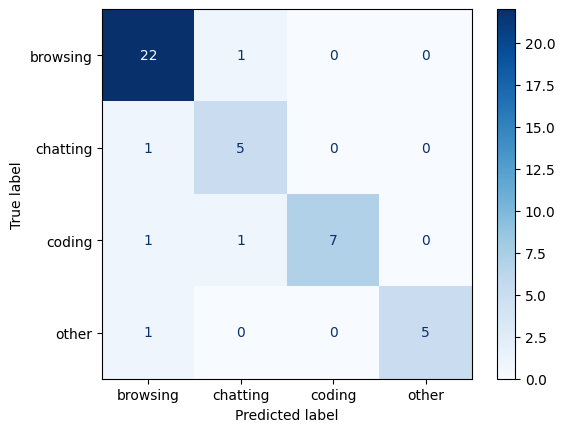

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from collections import defaultdict
import pickle
import logging
import os

# ================== Logging Setup ==================
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# ================== Utils ==================
def split_sessions(data, time_threshold=60):
    data = data.sort_values(by="timestamp").reset_index(drop=True)
    session_ids, current_session = [], 0
    prev_time = None

    for _, row in data.iterrows():
        curr_time = datetime.strptime(row["timestamp"], "%Y-%m-%d %H:%M:%S")
        if prev_time is None or (curr_time - prev_time).total_seconds() > time_threshold:
            current_session += 1
        session_ids.append(current_session)
        prev_time = curr_time

    data["session_id"] = session_ids
    return data

class ClickstreamDataset(Dataset):
    def __init__(self, sessions, labels):
        self.sessions = sessions
        self.labels = labels

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        return torch.tensor(self.sessions[idx], dtype=torch.long), self.labels[idx], len(self.sessions[idx])

def collate_fn(batch):
    sequences, labels, lengths = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.tensor(labels), torch.tensor(lengths)

# ================== Model ==================
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, encoder_outputs, lengths):
        attn_weights = self.attn(encoder_outputs).squeeze(-1)
        mask = torch.arange(encoder_outputs.size(1), device=lengths.device)[None, :] >= lengths[:, None]
        attn_weights.masked_fill_(mask, -1e4)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(encoder_outputs * attn_weights.unsqueeze(-1), dim=1)
        return context

class DMM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Flatten(),
            nn.ReLU(inplace=True),
            nn.Dropout1d(dropout),
            nn.Softplus(hidden_dim),
            nn.Linear(hidden_dim * 2, num_classes)
        )
        

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        context = self.attention(out, lengths)
        return self.fc(context)

# ================== Training Script ==================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    df = pd.read_csv("user_logs.csv")
    df = split_sessions(df)

    sessions = df.groupby("session_id")["description"].apply(list).tolist()
    labels = df.groupby("session_id")["type"].first().tolist()

    # Encoding
    all_tokens = set(token for session in sessions for token in session)
    token2idx = {token: idx + 1 for idx, token in enumerate(all_tokens)}
    token2idx["<PAD>"] = 0
    encoded_sessions = [[token2idx[token] for token in session] for session in sessions]

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)

    # Train-val split
    split_idx = int(len(encoded_sessions) * 0.8)
    train_data = ClickstreamDataset(encoded_sessions[:split_idx], encoded_labels[:split_idx])
    val_data = ClickstreamDataset(encoded_sessions[split_idx:], encoded_labels[split_idx:])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Class weight
    y_train = np.array([y for _, y, _ in train_loader.dataset])
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Grid search
    best_val_loss, best_params = float("inf"), None
    embed_dims = [64, 256]
    hidden_dims = [64, 256]
    dropouts = [0.3, 0.8]
    lrs = [0.001, 0.0005]

    for embed_dim in embed_dims:
        for hidden_dim in hidden_dims:
            for dropout in dropouts:
                for lr in lrs:
                    logging.info(f"Training model: embed={embed_dim}, hidden={hidden_dim}, dropout={dropout}, lr={lr}")
                    model = DMM(len(token2idx), embed_dim, hidden_dim, num_classes, dropout).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.CrossEntropyLoss(weight=class_weights)

                    for epoch in range(50):
                        model.train()
                        total_loss = 0
                        for x, y, lengths in train_loader:
                            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                            optimizer.zero_grad()
                            out = model(x, lengths)
                            loss = criterion(out, y)
                            loss.backward()
                            optimizer.step()
                            total_loss += loss.item()

                        avg_train_loss = total_loss / len(train_loader)

                        # Validation
                        model.eval()
                        val_loss, preds, targets = 0, [], []
                        with torch.no_grad():
                            for x, y, lengths in val_loader:
                                x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                                out = model(x, lengths)
                                val_loss += criterion(out, y).item()
                                preds += out.argmax(dim=1).cpu().tolist()
                                targets += y.cpu().tolist()
                        avg_val_loss = val_loss / len(val_loader)
                        logging.info(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

                        if avg_val_loss < best_val_loss:
                            best_val_loss = avg_val_loss
                            best_params = dict(embed_dim=embed_dim, hidden_dim=hidden_dim, dropout=dropout, lr=lr)
                            torch.save(model.state_dict(), "clickstream_dmm_best.pth")
                            with open("label_encoder.pkl", "wb") as f:
                                pickle.dump(label_encoder, f)

    logging.info(f"Best parameters: {best_params}")

    # Final evaluation
    model = DMM(
        len(token2idx),
        embed_dim=best_params['embed_dim'],
        hidden_dim=best_params['hidden_dim'],
        dropout=best_params['dropout'],
        num_classes=num_classes
    ).to(device)

# Lấy lr ra riêng để sau này còn dùng cho optimizer
    best_lr = best_params['lr']
    model.load_state_dict(torch.load("clickstream_dmm_best.pth"))
    model.eval()

    preds, targets = [], []
    with torch.no_grad():
        for x, y, lengths in val_loader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            out = model(x, lengths)
            preds += out.argmax(dim=1).cpu().tolist()
            targets += y.cpu().tolist()

    logging.info("\n" + classification_report(targets, preds, target_names=label_encoder.classes_))

if __name__ == "__main__":
    train()


2025-04-14 16:09:52,349 | INFO | Using device: cuda
2025-04-14 16:09:52,697 | INFO | Training model: embed=64, hidden=64, dropout=0.3, lr=0.001


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9696x64 and 128x1)

In [19]:
torch.save(model.state_dict(), 'clickstream_model_beta(5).pth')

In [20]:
import joblib
joblib.dump(token2idx, "token2idx(4).pkl")


['token2idx(4).pkl']

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Đọc dữ liệu từ CSV (đổi đường dẫn nếu cần)
df = pd.read_csv("user_logs.csv")

# Giả sử cột label tên là 'label'
labels = df['type']

# Khởi tạo và fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Lưu ra file
joblib.dump(label_encoder, "label_encoder(5).pkl")

print("✅ Đã lưu label_encoder.pkl thành công!")


✅ Đã lưu label_encoder.pkl thành công!


In [10]:
import torch

state_dict = torch.load("clickstream_model_beta(4).pth", map_location="cpu")
embed_weight = state_dict["embedding.weight"]
vocab_size = embed_weight.shape[0]
vocab_size


519

In [11]:
model = LSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, num_classes=4, dropout=0.3)
model.load_state_dict(state_dict)


<All keys matched successfully>

In [30]:
TOKEN2IDX_FILE = "token2idx.pkl"
token2idx = joblib.load(TOKEN2IDX_FILE)
vocab_size = len(token2idx) + 1


In [31]:
vocab_size

519

In [34]:
import pyro
import pyro.distributions as dist
import torch    
from torch.nn import functional as F
import pyro.poutine as poutine